# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
data_filename = 'tactics/data/stats/metrics_test_t1600_sf14.csv'
df = pd.read_csv(data_filename)

In [3]:
df.describe()

,match,num_suggestions,correct_move,tactic_ground_div,tactic_ground_avg
count,8390.000000,3732.000000,3732.000000,3732.000000,3732.000000
mean,0.444815,9.317256,0.147374,105.426742,164.865208
std,0.496975,14.147104,0.354526,154.776286,223.989425
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,13.400686,19.375000
50%,0.000000,4.000000,0.000000,32.636069,51.000000
75%,1.000000,9.000000,0.000000,100.204720,276.500000
max,1.000000,77.000000,1.000000,525.037171,813.000000


## Generate graphs

In [5]:
def calculate_metrics(df): # TODO: refactor this and the method in analysis.py
    agg = df.groupby('tactic_text').aggregate(np.nansum).reset_index()
    agg['avg_tactic_ground_avg'] = agg['tactic_ground_avg'] / agg['match']
    agg['coverage'] = agg['match'] / df.groupby(['position', 'move']).ngroups
    agg['accuracy'] = agg['correct_move'] / agg['match']
    return agg

In [12]:
def generate_frequency_graph(df, metric_fname: str, title: str='?', xlabel: str=None, bins: int=20, left: int=0, right=None):
    mask = df['tactic_text'].isin(['ground', 'sf14', 'maia_1600', 'random'])
    df_masked = df[~mask]
    plt.hist(df_masked[metric_fname], bins=bins) # exclude default tactics from histogram
    plt.axvline(df[df['tactic_text'] == "random"][metric_fname].values, linestyle='dashed', color='blue', label='random move tactic')
    plt.axvline(df[df['tactic_text'] == "ground"][metric_fname].values, linestyle='dashed', color='green', label='ground move tactic')
    plt.axvline(df[df['tactic_text'] == "sf14"][metric_fname].values, linestyle='dashed', color='red', label='sf14 move tactic')
    plt.axvline(df[df['tactic_text'] == "maia_1600"][metric_fname].values, linestyle='dashed', color='magenta', label='maia-1600 move tactic')
    plt.title(f'Histogram of {title}')
    plt.xlabel(xlabel if xlabel else metric_fname)
    plt.ylabel('Frequency')
    plt.xlim(left=left, right=right)
    plt.legend(loc=1)
    plt.show()

In [7]:
df_metrics = calculate_metrics(df)

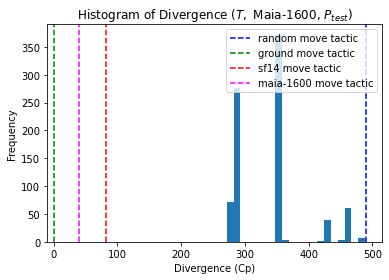

In [13]:
generate_frequency_graph(df_metrics, 'avg_tactic_ground_avg', "Divergence $(T,$ Maia-1600, $P_{test})$", "Divergence (Cp)", left=-10)

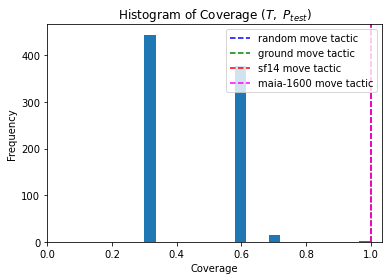

In [14]:
generate_frequency_graph(df_metrics, 'coverage', "Coverage $(T,$ $P_{test})$", "Coverage")

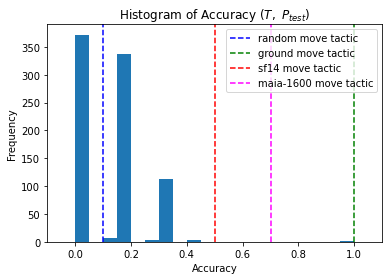

In [15]:
generate_frequency_graph(df_metrics, 'accuracy', "Accuracy $(T,$ $P_{test})$", "Accuracy", left=-0.1, right=1.1)

In [22]:
final = df_metrics.sort_values(by = ['coverage'], ascending = [False])
final[final['tactic_text'] == 'f(A,B,C):-legal_move(B,C,A),behind(B,C,D,A),behind(B,D,E,A),behind(B,E,D,A),behind(B,D,C,A)']

,tactic_text,match,num_suggestions,correct_move,tactic_ground_div,tactic_ground_avg,avg_tactic_ground_avg,coverage,accuracy
493,"f(A,B,C):-legal_move(B,C,A),behind(B,C,D,A),be...",6,30.0,1.0,1128.877469,1723.055556,287.175926,0.6,0.166667


In [ ]:
mask = agg['tactic_text'].isin(['ground', 'engine_best'])
agg_masked = agg[~mask]
avg_div = agg_masked['avg_tactic_ground_div'].mean()
random_div = agg[agg['tactic_text'] == "f(A,B,C):-legal_move(B,C,A)"]['avg_tactic_ground_div'].values
(random_div - avg_div) / random_div * 100

# Analyze Position Features

In [ ]:
df['pos_move'] = df['position'] + "," + df['move']

In [ ]:
df2 = df.groupby('pos_move')
agg = df2.aggregate(np.sum)
agg

In [ ]:
plt.hist(agg['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [ ]:
high_exec = agg[agg['exec_time'] > 100]
high_exec = high_exec.sort_values(by = ['exec_time'], ascending = [False])
high_exec

In [ ]:
low_exec = agg[agg['exec_time'] <= 100]
plt.hist(low_exec['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [ ]:
num_exs = [1, 5, 20, 100]
time_vals = [27.5, 60 + 33, 60 * 6 + 33, 33 * 60 + 8]
num_tactics = [9, 117, 469, 837]

In [ ]:
plt.plot(num_exs, time_vals)
plt.xlabel('Number of train examples')
plt.ylabel('Execution time (s)')
plt.show()

In [ ]:
plt.plot(num_exs, num_tactics)
plt.xlabel('Number of train examples')
plt.ylabel('Number of tactics learned')
plt.show()

In [ ]:
plt.plot(num_tactics, time_vals)
plt.xlabel('Number of tactics learned')
plt.ylabel('Execution time (s)')
plt.show()

# Calculate Dataset Metrics

In [ ]:
from collections import Counter

total_games = 0
valid_elo = 0
total_pos = 0
total_elo = 0
game_count = Counter()

pgn_path = 'tactics/data/lichess_db_standard_rated_2013-01.pgn'

In [ ]:
offsets = []
handle = open(pgn_path)
header = chess.pgn.read_headers(handle)

In [ ]:
header.get('Termination')


In [ ]:
import chess.pgn

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            total_elo += int(white_elo)
            total_elo += int(black_elo)
            valid_elo += 1
        game_count[game.headers['Event']] += 1

In [ ]:
print('Total games', total_games)
avg_elo = total_elo / (2 * valid_elo)
print('Average ELO', avg_elo)

In [ ]:
variance = 0

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            variance += (int(white_elo) - avg_elo) ** 2
            variance += (int(black_elo) - avg_elo) ** 2
        game_count[game.headers['Event']] += 1

In [ ]:
import math

print('SD', math.sqrt(variance / valid_elo))

# Test Evaluation

In [ ]:
import chess
import chess.engine
from tactics.util import *

board = chess.Board('r1bqkb1r/ppp1pnpp/3p4/7Q/8/3B4/PPP2PPP/RNB2RK1 w kq - 0 10')
move_names = [
    'b1c3',
    'c1g5',
    'd3c4',
    'f1e1'
]
moves = [chess.Move.from_uci(move_name) for move_name in move_names]
engine_path = get_lc0_cmd(LC0, MAIA_1600) + ['--nncache=0']
#engine_path = STOCKFISH
mate_score = 2000
n = 10

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    tmp_analysis = engine.analyse(board, limit=chess.engine.Limit(nodes=1), multipv=n, game=object())
    top_results = [(root['pv'][0], root['score'].relative.score(mate_score=mate_score)) for root in tmp_analysis]
    top_n_results = top_results[:n]
top_n_results

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    all_evals = get_evals(engine, board, board.legal_moves)
    all_evals.sort(key=lambda eval: eval[1], reverse=True)
    top_n_results = all_evals[:n]
top_n_results

In [ ]:
def get_evals(engine: chess.engine.SimpleEngine, board: chess.Board, suggestions: List[chess.Move], mate_score: int=2000) -> List[Tuple[chess.Move, int]]:
    "Obtain engine evaluations for a list of moves in a given position"

    evals = []
    for move in suggestions:
        tmp_board = chess.Board(board.fen())
        tmp_board.push(move)
        if tmp_board.outcome() is not None:
            move_score = mate_score if tmp_board.is_checkmate() else -mate_score
            evals.append((move, move_score))
            continue
        limit = chess.engine.Limit(nodes=1)
        # prev_eval = engine.analyse(board, limit=limit, game=object()) # https://stackoverflow.com/a/66251120
        # print(prev_eval) 
        curr_eval = engine.analyse(tmp_board, limit=limit, game=object())
        print(curr_eval)
        orig_turn = board.turn
        if 'pv' in curr_eval:
            # prev_score = prev_eval['score'].pov(orig_turn)
            curr_score = curr_eval['score'].pov(orig_turn)
            move_score = curr_score.score(mate_score=mate_score)
            evals.append((move, move_score))
    return evals

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    evals = get_evals(engine, board, moves)
evals